In [1]:
import ann_visualizer
import copy
import datetime
from IPython.display import display, Image
import logging
import matplotlib.pyplot as plt
import numpy
import os
import pandas
import pickle
import plotly
import pyarrow.parquet as pq
import random
import six
import tensorflow as tf

import CS230

plotly.offline.init_notebook_mode(connected=True)
#tf.enable_eager_execution()

# model 5: LSTM

In [2]:
MODEL_NAME = 'model-5'
EPOCHS = 200
SEQUENCE_LENGTH = 100
SESS_DATE_TIME = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

MODEL_DIR = os.path.join('models', MODEL_NAME)
SESS_DIR = os.path.join(MODEL_DIR, SESS_DATE_TIME)
for dir_path in [MODEL_DIR, SESS_DIR]:
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)

logger = CS230.common.get_logger()
logger.info(SESS_DIR)

09-17-08 | INFO | models/model-5/20190603091708


# load and format data

In [3]:
FILE_PATHS = []

for dir_path, dir_names, file_names in os.walk(CS230.data.DATA_DIR):
    if dir_path.startswith('.'):
        continue
    
    for file_name in file_names:
        if file_name.endswith('.parquet'):
            file_path = os.path.join(dir_path, file_name)
            FILE_PATHS.append(file_path)
    
    if FILE_PATHS:
        break  # exit after loading files from 1 directory

FILE_PATHS.sort()
FILE_PATHS

['/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_01_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_01_02_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_02_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_02_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_03_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_04_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140222_01_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140222

In [4]:
COLS_X = ['axCG', 'ayCG', 'azCG', 'brake', 'chassisAccelFL', 'chassisAccelFR', 'chassisAccelRL', 'chassisAccelRR', 
          'clutch', 'engineSpeed', 'handwheelAngle', 'deflectionFL', 'deflectionFR',
          'horizontalSpeed', 'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'throttle', 'vxCG', 'vyCG', 'vzCG', 
          'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle', 'yawRate']  #'deflectionRL', 'deflectionRR', 

COLS_Y = ['axCG', 'ayCG', 'azCG', 'chassisAccelFL', 'chassisAccelFR', 'chassisAccelRL', 'chassisAccelRR',
          'horizontalSpeed', 'pitchAngle', 'rollAngle', 'vxCG', 'vyCG', 'vzCG',
          'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle']

In [5]:
def get_df_x(file_path, cols=COLS_X):
    df = CS230.data.load(file_path)
    df = CS230.data.stride_rows(df, stride=10)
    df.dropna(axis=0, inplace=True)
    df = df.iloc[:-1].reset_index(drop=True)
    return df[cols]

In [6]:
def get_df_y(file_path, cols=COLS_Y):
    df = CS230.data.load(file_path)
    df = CS230.data.stride_rows(df, stride=10)
    df.dropna(axis=0, inplace=True)
    df = df.iloc[1:].reset_index(drop=True)
    return df[cols]

In [7]:
def get_tensor_x(df):
    x = numpy.reshape(df.values, (df.shape[0], 1, df.shape[1]))
    x = tf.cast(x, tf.float64)
    return x

In [8]:
def get_tensor_y(df):
    y = tf.cast(df.values, tf.float64)
    return y

In [9]:
DATA = {}

for name, file_path in [('train', FILE_PATHS[0]), ('dev', FILE_PATHS[1])]:
    DATA[name] = {'df': {}, 'tensor': {}}
    DATA[name]['df']['x'] = get_df_x(file_path)
    DATA[name]['df']['y'] = get_df_y(file_path)
    #DATA[name]['tensor']['x'] = get_tensor_x(DATA[name]['df']['x'])
    #DATA[name]['tensor']['y'] = get_tensor_y(DATA[name]['df']['y'])
    
    DATA[name]['generator'] = tf.keras.preprocessing.sequence.TimeseriesGenerator(
                                DATA[name]['df']['x'].values,
                                DATA[name]['df']['y'].values,
                                length=SEQUENCE_LENGTH, sampling_rate=1  #, shuffle=True
                            )
    DATA[name]['sequence_length'] = SEQUENCE_LENGTH
    
    DATA[name]['m'] = DATA[name]['df']['x'].shape[0]
    DATA[name]['n_x'] = DATA[name]['df']['x'].shape[1]
    DATA[name]['n_y'] = DATA[name]['df']['y'].shape[1]

# explore input data

In [10]:
for set_name, _dict in six.iteritems(DATA):
    for name, df in six.iteritems(_dict['df']):
        print('%s %s %s' % (set_name, name, df.shape))
        display(df.head(3))
    print('%s m: %s' % (set_name, _dict['m']))
    print('%s n_x: %s' % (set_name, _dict['n_x']))
    print('%s n_y: %s' % (set_name, _dict['n_y']))
    print('\n')

train x (49095, 28)


,axCG,ayCG,azCG,brake,chassisAccelFL,chassisAccelFR,chassisAccelRL,chassisAccelRR,clutch,engineSpeed,...,throttle,vxCG,vyCG,vzCG,wheelAccelFL,wheelAccelFR,wheelAccelRL,wheelAccelRR,yawAngle,yawRate
0,0.94,0.23,7.78,0.0,9.300,9.398,7.564,10.094,0.0,1890,...,11.8,6.12,-0.27,-0.22,8.63,10.30,10.99,7.06,-14.01,5.81
1,0.94,0.23,7.78,0.0,8.545,10.094,9.398,9.781,0.0,1890,...,11.8,6.13,-0.28,-0.24,8.73,9.52,12.07,7.85,-13.96,5.81
2,0.94,0.23,7.78,0.0,9.349,9.663,9.594,10.889,0.0,1914,...,11.8,6.13,-0.28,-0.26,7.75,10.59,10.20,9.12,-13.90,5.81


train y (49095, 18)


,axCG,ayCG,azCG,chassisAccelFL,chassisAccelFR,chassisAccelRL,chassisAccelRR,horizontalSpeed,pitchAngle,rollAngle,vxCG,vyCG,vzCG,wheelAccelFL,wheelAccelFR,wheelAccelRL,wheelAccelRR,yawAngle
0,0.94,0.23,7.78,8.545,10.094,9.398,9.781,6.14,-2.93,1.74,6.13,-0.28,-0.24,8.73,9.52,12.07,7.85,-13.96
1,0.94,0.23,7.78,9.349,9.663,9.594,10.889,6.14,-2.94,1.70,6.13,-0.28,-0.26,7.75,10.59,10.20,9.12,-13.90
2,0.19,1.52,10.73,9.300,9.320,8.584,10.860,6.13,-2.89,1.89,6.12,-0.26,-0.24,8.63,11.38,9.81,9.71,-13.91


train m: 49095
train n_x: 28
train n_y: 18


dev x (79099, 28)


,axCG,ayCG,azCG,brake,chassisAccelFL,chassisAccelFR,chassisAccelRL,chassisAccelRR,clutch,engineSpeed,...,throttle,vxCG,vyCG,vzCG,wheelAccelFL,wheelAccelFR,wheelAccelRL,wheelAccelRR,yawAngle,yawRate
0,0.36,-0.56,9.80,0.0,9.83,9.928,9.163,9.182,0.0,0,...,0.2,-0.01,-0.02,0.02,10.2,9.91,8.14,7.85,-4.31,0.56
1,-0.24,0.66,9.83,0.0,9.81,9.928,9.163,9.153,0.0,0,...,0.2,-0.01,-0.01,0.02,10.4,10.10,8.14,8.04,-4.31,0.06
2,-0.19,0.54,9.56,0.0,9.83,9.898,9.182,9.133,0.0,0,...,0.2,-0.01,-0.01,0.01,10.5,10.10,8.44,7.85,-4.30,-0.32


dev y (79099, 18)


,axCG,ayCG,azCG,chassisAccelFL,chassisAccelFR,chassisAccelRL,chassisAccelRR,horizontalSpeed,pitchAngle,rollAngle,vxCG,vyCG,vzCG,wheelAccelFL,wheelAccelFR,wheelAccelRL,wheelAccelRR,yawAngle
0,-0.24,0.66,9.83,9.81,9.928,9.163,9.153,0.01,-0.03,1.03,-0.01,-0.01,0.02,10.4,10.10,8.14,8.04,-4.31
1,-0.19,0.54,9.56,9.83,9.898,9.182,9.133,0.01,-0.03,1.03,-0.01,-0.01,0.01,10.5,10.10,8.44,7.85,-4.30
2,0.05,0.08,9.97,9.83,9.898,9.231,9.182,0.01,-0.03,1.03,-0.01,-0.01,0.02,10.3,9.71,8.24,8.14,-4.30


dev m: 79099
dev n_x: 28
dev n_y: 18




# build model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 28)           6384      
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 28)           812       
_________________________________________________________________
dense_1 (Dense)              (None, 100, 18)           522       
Total params: 7,718
Trainable params: 7,718
Non-trainable params: 0
_________________________________________________________________


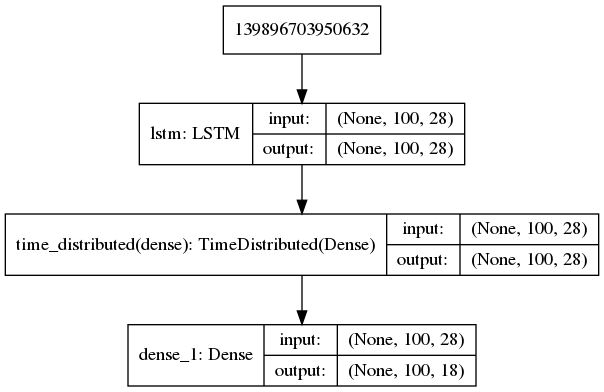

Instructions for updating:
Use tf.cast instead.


In [11]:
m = DATA['train']['m']
n_x = DATA['train']['n_x']
n_y = DATA['train']['n_y']
sequence_length = DATA['train']['sequence_length']

# build model
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(n_x, return_sequences=True, input_shape=(sequence_length, n_x), dropout=0.1, recurrent_dropout=0.1))

#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_x, activation='sigmoid')))

#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.LSTM(n_x, dropout=0.1, recurrent_dropout=0.1))

#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(n_y, activation='linear'))

# summarize model
model.summary()

# visualize model
file_path = os.path.join(SESS_DIR, 'architecture.png')
tf.keras.utils.plot_model(model, file_path, show_shapes=True, show_layer_names=True)
display(Image(filename=file_path))

# set optimizer
#optimizer = tf.train.AdamOptimizer(0.01)
optimizer = tf.keras.optimizers.Adam(0.01, decay=1e-4)
#optimizer = tf.keras.optimizers.SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)

# compile model
model.compile(
    optimizer=optimizer, 
    loss='mean_squared_error', 
    metrics=['mean_absolute_error']
)

# set callbacks

In [12]:
file_path = os.path.join(SESS_DIR, 'model_epoch{epoch}.h5')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(file_path, monitor='loss', verbose=1, 
                                                         save_weights_only=False, save_best_only=True, mode='min')

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-2, patience=3, verbose=1)

callbacks = [checkpoint_callback, stop_callback]

# (optional) load prior checkpoint

In [13]:
#file_path = os.path.join(MODEL_DIR, 'model_epoch27.h5')
#model.load_weights(file_path)

# train model on training set

In [14]:
history = model.fit_generator(
    DATA['train']['generator'], 
    epochs=EPOCHS, 
    steps_per_epoch=len(DATA['train']['generator']), 
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200


InternalError: Dst tensor is not initialized.
	 [[{{node training/Adam/gradients/lstm/while/clip_by_value_2/Minimum_grad/LessEqual/StackPopV2}}]]
	 [[{{node loss/mul}}]]

# save model

In [ ]:
file_name = 'model_end_%s.h5' % history.history['mean_absolute_error'][-1]
model.save(os.path.join(SESS_DIR, file_name))

# plot training error per epoch

In [ ]:
file_path = os.path.join(SESS_DIR, 'training_error.jpeg')
title = 'Model 5: traning mean absolute error: %s' % history.history['mean_absolute_error'][-1]

# make plot
trace = plotly.graph_objs.Scatter(
    x=list(range(1, len(pandas.DataFrame(history.history['mean_absolute_error']))+1)),
    y=history.history['mean_absolute_error']
)
layout = plotly.graph_objs.Layout(
    title=title,
    xaxis=dict(title='epochs'),
    yaxis=dict(title='mean absolute error')
)
fig = plotly.graph_objs.Figure(data=[trace], layout=layout)

# save plot to file
CS230.data.write_image(fig, file_path)

# display plot from file
display(Image(filename=file_path))

# predict on dev set

In [ ]:
predictions = model.predict(DATA['dev']['generator'])

In [ ]:
df_predictions = pandas.DataFrame(predictions, columns=COLS_Y)

In [ ]:
df_error = DATA['dev']['df']['y'][COLS_Y] - df_predictions[COLS_Y]

# explore dev set results

In [ ]:
sets = [('dev x', DATA['dev']['df']['x']), ('dev y', DATA['dev']['df']['y']), ('predictions', df_predictions), ('error', df_error)]

indexes = [random.randint(1, len(DATA['dev']['df']['x'])) for x in range(3)]

for name, df in sets:
    print(name)
    display(df.iloc[indexes,:])
for name, df in sets:
    print('%s max' % name)
    display(pandas.DataFrame(df.max()).T)
for name, df in sets:
    print('%s min' % name)
    display(pandas.DataFrame(df.min()).T)